In [1]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import math
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
import mpl_style

H0 = 72.
cosmo = FlatLambdaCDM(H0, Om0=0.3)
h = H0/100

In [2]:
hdulist = fits.open('../petroC_nsa_gzoo_totssfr_info.fits')
tbdata = hdulist[1].data
#color = tbdata['col12'] #^{0.1}(g-r), K-E corrected to z=0.1, model
#M_r = tbdata['col11'] #^{0.1}(M_r) - 5\log h, K-E corrected to z=0.1, model
color = tbdata['col10'] #^{0.1}(g-r), K-E corrected to z=0.1, petro
M_r = tbdata['col9'] #^{0.1}(M_r) - 5\log h, K-E corrected to z=0.1, petro
centsat = tbdata['col4_2'] #if BRIGHTEST galaxy in group, is 1, otherwise 2
pfeatures = tbdata['t01_smooth_or_features_a02_features_or_disk_weighted_fraction']
psmooth = tbdata['t01_smooth_or_features_a01_smooth_weighted_fraction']
absmag = tbdata['ABSMAG']
absmag_r = absmag[:,4]
ssfr = tbdata['AVG_SSFR']
ns_z = tbdata['Z_1'] #heliocentric redshift from NSatlas
z = tbdata['Z_2'] #Schlegel redshift from mpa-jhu
z_warn = tbdata['Z_WARNING'] #if non-zero, don't sue Schlegel redshift
mass = tbdata['MASS'] #stellar mass from K correction fit, in h^-2 Msun units
hdulist.close()

In [3]:
#Magnitude limit calculation
z_lim = 0.06
d = cosmo.luminosity_distance(z_lim).to(u.pc)
m = 17
M_limit = m - 5*math.log(d.value,10) + 5 
adj_M_limit = M_limit - 5*math.log(h,10)

In [4]:
redpas_pfeatures = []
redpas_psmooth = []
redpas_color = []
redpas_sfr = []
redpas_mr = []
redpas_mass = []

bluact_pfeatures = []
bluact_psmooth = []
bluact_color = []
bluact_sfr = []
bluact_mr = []
bluact_mass = []

redact_pfeatures = []
redact_psmooth = []
redact_color = []
redact_sfr = []
redact_mr = []
redact_mass = []

for i in np.arange(pfeatures.size):
    if z[i] > 0.01 and z[i] < 0.06 and z_warn[i] == 0:# and absmag_r[i] < M_limit:
        color_line = 0.7 - 0.032*(M_r[i] + 16.5)
        active_line = -10 + 0.094*(M_r[i] + 15)
        logSSFR = ssfr[i]
        if color[i] > color_line: #red galaxies
            if logSSFR <= active_line: #passive galaxies - redpas type
                redpas_pfeatures.append((pfeatures[i], centsat[i]))
                redpas_psmooth.append((psmooth[i], centsat[i]))
                redpas_color.append((color[i], centsat[i]))
                redpas_sfr.append((logSSFR, centsat[i]))
                redpas_mr.append((M_r[i], centsat[i]))
                redpas_mass.append((mass[i], centsat[i]))
            else: #red and active - redact type
                redact_pfeatures.append((pfeatures[i], centsat[i]))
                redact_psmooth.append((psmooth[i], centsat[i]))
                redact_color.append((color[i], centsat[i]))
                redact_sfr.append((logSSFR,centsat[i]))
                redact_mr.append((M_r[i],centsat[i]))
                redact_mass.append((mass[i], centsat[i]))
        elif logSSFR >= active_line and color[i] < color_line: #blue and active - bluact type
            bluact_pfeatures.append((pfeatures[i],centsat[i]))
            bluact_psmooth.append((psmooth[i],centsat[i]))
            bluact_color.append((color[i],centsat[i]))
            bluact_sfr.append((logSSFR,centsat[i]))
            bluact_mr.append((M_r[i],centsat[i]))
            bluact_mass.append((mass[i],centsat[i]))

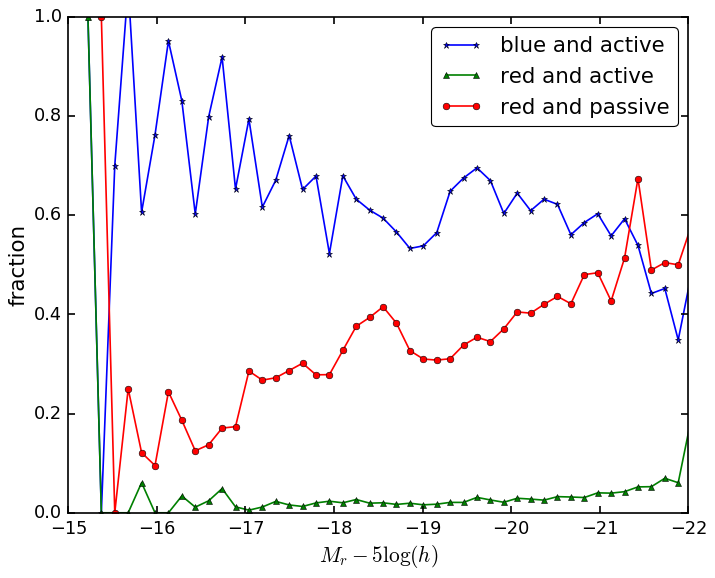

In [31]:
fig = plt.figure(figsize=(10,8))
bluact_mr_cent = [x[0] for x in bluact_mr if x[1]==1]
redact_mr_cent = [x[0] for x in redact_mr if x[1]==1]
redpas_mr_cent = [x[0] for x in redpas_mr if x[1]==1]
all_mr_cent = np.concatenate((bluact_mr_cent,redact_mr_cent,redpas_mr_cent))
plt.style.use(mpl_style.style1)

bluact_mr_hist,a = np.histogram(bluact_mr_cent, bins=50)
redact_mr_hist,b = np.histogram(redact_mr_cent, bins=50)
redpas_mr_hist,c = np.histogram(redpas_mr_cent, bins=50)
all_mr_hist, bin_edges = np.histogram(all_mr_cent, bins=50)

bluact_mr_hist = bluact_mr_hist/all_mr_hist
redact_mr_hist = redact_mr_hist/all_mr_hist
redpas_mr_hist = redpas_mr_hist/all_mr_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_mr_hist, c='b', marker='*', label='blue and active')
plt.plot(bin_edges_adj, redact_mr_hist, c='g', marker='^', label='red and active')
plt.plot(bin_edges_adj, redpas_mr_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of centrals')
plt.xlabel(r'$M_r - 5\log(h)$')
plt.xlim(-15,-22)
plt.ylim(0,1)

plt.show()

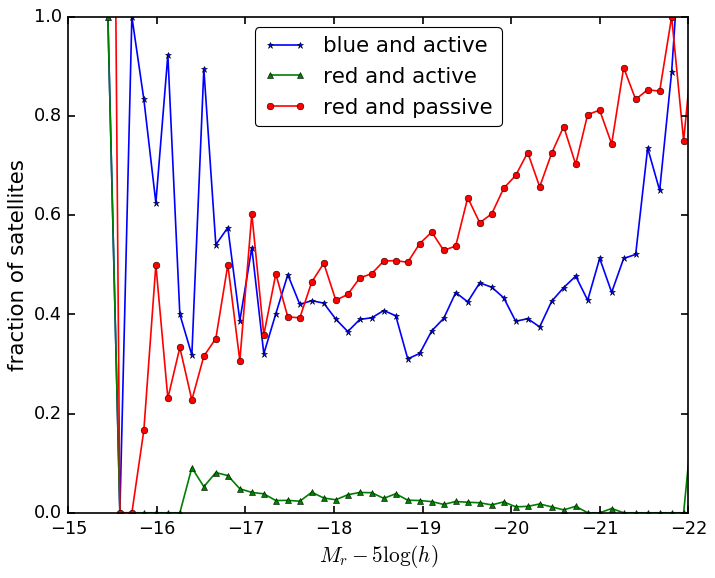

In [32]:
fig = plt.figure(figsize=(10,8))
bluact_mr_sat = [x[0] for x in bluact_mr if x[1]==2]
redact_mr_sat = [x[0] for x in redact_mr if x[1]==2]
redpas_mr_sat = [x[0] for x in redpas_mr if x[1]==2]
all_mr_sat = np.concatenate((bluact_mr_sat,redact_mr_sat,redpas_mr_sat))
plt.style.use(mpl_style.style1)

bluact_mr_hist,a = np.histogram(bluact_mr_sat, bins=50)
redact_mr_hist,b = np.histogram(redact_mr_sat, bins=50)
redpas_mr_hist,c = np.histogram(redpas_mr_sat, bins=50)
all_mr_hist, bin_edges = np.histogram(all_mr_sat, bins=50)

bluact_mr_hist = bluact_mr_hist/all_mr_hist
redact_mr_hist = redact_mr_hist/all_mr_hist
redpas_mr_hist = redpas_mr_hist/all_mr_hist

bin_edges_adj = bin_edges[1:]

plt.plot(bin_edges_adj, bluact_mr_hist, c='b', marker='*', label='blue and active')
plt.plot(bin_edges_adj, redact_mr_hist, c='g', marker='^', label='red and active')
plt.plot(bin_edges_adj, redpas_mr_hist, c='r', marker='o', label='red and passive')
plt.legend()
plt.ylabel('fraction of satellites')
plt.xlabel(r'$M_r - 5\log(h)$')
plt.xlim(-15,-22)
plt.ylim(0,1)

plt.show()

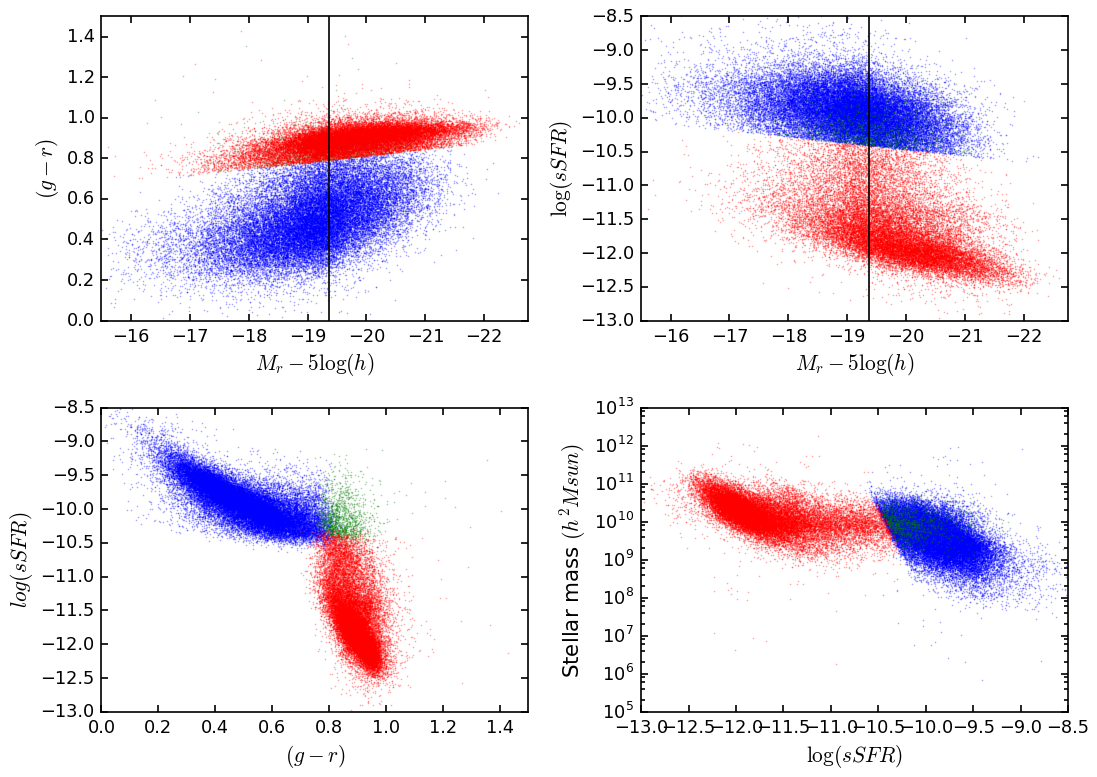

In [28]:
fig = plt.figure(figsize=(14,10))

colors = [[x[0] for x in bluact_color], [x[0] for x in redact_color], [x[0] for x in redpas_color]] #this method gets the first element of the tuples
mrs = [[x[0] for x in bluact_mr], [x[0] for x in redact_mr], [x[0] for x in redpas_mr]]
sfrs = [[x[0] for x in bluact_sfr], [x[0] for x in redact_sfr], [x[0] for x in redpas_sfr]]
masses = [[x[0] for x in bluact_mass], [x[0] for x in redact_mass], [x[0] for x in redpas_mass]]
plot_color = ['b', 'g', 'r']
plt.style.use(mpl_style.style1)
#top left plot
ax1 = fig.add_subplot(221)
for i in np.arange(3):
    ax1.scatter(mrs[i], colors[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax1.set_ylabel(r'$(g-r)$')
ax1.set_xlabel(r'$M_r - 5\log(h)$')
ax1.set_ylim(0, 1.5)
ax1.set_xlim(-15.5, -22.75)

#top right plot
ax2 = fig.add_subplot(222)
for i in np.arange(3):
    ax2.scatter(mrs[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
plt.axvline(adj_M_limit,c='k')
ax2.set_ylabel(r'$\log(sSFR)$')
ax2.set_xlabel(r'$M_r - 5\log(h)$')
ax2.set_ylim(-13, -8.5)
ax2.set_xlim(-15.5, -22.75)

#bottom left plot
ax3 = fig.add_subplot(223)
for i in np.arange(3):
    ax3.scatter(colors[i], sfrs[i], color = plot_color[i], s=0.1, alpha=0.5)
ax3.set_ylabel(r'$log(sSFR)$')
ax3.set_xlabel(r'$(g-r)$')
ax3.set_ylim(-13, -8.5)
ax3.set_xlim(0,1.5)

#bottom right plot
ax4 = fig.add_subplot(224)
for i in np.arange(3):
    ax4.scatter(sfrs[i], masses[i], color = plot_color[i], s=0.1, alpha=0.5)
ax4.set_ylabel(r'Stellar mass $(h^2 Msun)$')
ax4.set_xlabel(r'$\log(sSFR)$')
ax4.set_xlim(-13, -8.5)
ax4.set_yscale('log')
#ax3.set_xlim(0,1.5)

plt.tight_layout()
plt.show()

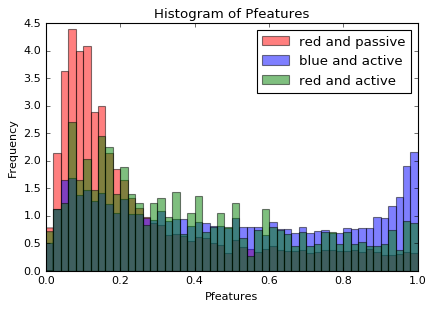

In [23]:
plt.hist(redpas_pfeatures, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='red and passive')
plt.hist(bluact_pfeatures, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='blue and active')
plt.hist(redact_pfeatures, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='red and active')
plt.xlabel('Pfeatures')
plt.ylabel('Frequency')
plt.title('Histogram of Pfeatures')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.hist(redpas_psmooth, 50, normed=1, facecolor='r', alpha=0.5, ec='black', label='red and passive')
plt.hist(bluact_psmooth, 50, normed=1, facecolor='b', alpha=0.5, ec='black', label='blue and active')
plt.hist(redact_psmooth, 50, normed=1, facecolor='g', alpha=0.5, ec='black', label='red and active')
plt.xlabel('psmooth')
plt.ylabel('Frequency')
plt.title('Histogram of psmooth')
plt.legend(loc='upper center')
plt.show()